In [1]:
import time
import pickle
import torch
import copy
import torch.nn          as nn
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt 
import seaborn           as sns

from mpl_toolkits.mplot3d import Axes3D
from typing           import List
from torch.utils.data import Dataset, DataLoader
from torch_geometric.loader import DataLoader as PyG_Dataloader

from config import (
    PATH_SUMMARY_DATASETS
)

%matplotlib inline

torch.manual_seed(42)
sns.set_theme(style="white")

---

# Build baseline regression model

In this notebook we are going to build a simple regression model which holds as a very rough baseline to the other models. The dataset for this model will be a simple table with the following columns
- cell-line indicator (`CELL_LINE_NAME`)
- drug (`DRUG_ID`)
- gene expression features (`<gene_id>_gexpr`)
- mutation features (`<gene_id>_mut`)
- copy number features (`<gene_id>_cnvg`, `<gene_id>_cnvp`)
- target value (`LN_IC50`)

Notes: 
- for the same cell-line `i`, there will be drug values `1, ...j, ..., q`, where `q = # of drugs` and `i = {1, ..., m}`, where `i = # of cell-lines`
- for the same cell-line `i` the feature values are exactly the same
  - this is because the gene expression, mutation and copy number values are PER CELL-LINE and HAVE NOTHING TO DO WITH THE DRUG
- the ic50 value however will be per cell-line drug tuple and thus be dependent on the cell-line as well as the drug

Steps: 
- [ ] get the drug response matrix from the previous notebooks
- [ ] get the tabular cell-line gene matrix from the previous notebooks
- [ ] merge both into a single matrix
- [ ] check the distribution of missing (`NaN`) values across the matrix
  - [ ] How sparse is it? 
  - this can help with filtering the graph and tabular datasets from the previous notebooks since the networks shouldn't handle missing values

In [2]:
# Read drug-response matrix.
with open(f'{PATH_SUMMARY_DATASETS}drug_response_matrix__gdsc2.pkl', 'rb') as f: 
    drm = pickle.load(f) 

# Read cell-line gene matrix.
with open(f'{PATH_SUMMARY_DATASETS}cell_line_gene_matrix.pkl', 'rb') as f:
    cl_gene_mat = pickle.load(f) 

In [3]:
print(drm.shape)
print("Number of unique drug names: ", len(drm.DRUG_ID.unique()))
print("Number of unique drug-ids: ", len(drm.DRUG_NAME.unique()))
print("Number of unique cell-lines: ", len(drm.CELL_LINE_NAME.unique()))
drm.head(5)

(100972, 5)
Number of unique drug names:  152
Number of unique drug-ids:  152
Number of unique cell-lines:  806


,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,DATASET,LN_IC50
3441054,22RV1,1003,Camptothecin,GDSC2,-3.142631
3459252,22RV1,1004,Vinblastine,GDSC2,-4.459259
3508920,22RV1,1006,Cytarabine,GDSC2,3.826935
3551362,22RV1,1010,Gefitinib,GDSC2,4.032555
3571270,22RV1,1011,Navitoclax,GDSC2,3.963435


In [4]:
print(cl_gene_mat.shape)
print("Number of unique cell-lines: ", len(cl_gene_mat.CELL_LINE_NAME.unique()))
cl_gene_mat.head(5)

(806, 3433)
Number of unique cell-lines:  806


,CELL_LINE_NAME,FBXL12_gexpr,PIN1_gexpr,PAK4_gexpr,GNA15_gexpr,ARPP19_gexpr,EAPP_gexpr,MOK_gexpr,MTHFD2_gexpr,TIPARP_gexpr,...,PDHX_mut,DFFB_mut,FOSL1_mut,ETS1_mut,EBNA1BP2_mut,MYL9_mut,MLLT11_mut,PFKL_mut,FGFR4_mut,SDHB_mut
0,22RV1,7.023759,6.067534,4.318750,3.261427,6.297582,8.313991,5.514912,10.594112,5.222366,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,23132-87,6.714387,5.695096,4.536146,3.295886,7.021037,8.500080,4.862145,10.609245,6.528668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,42-MG-BA,7.752402,5.475753,4.033714,3.176525,7.279671,8.013367,4.957332,11.266705,7.445954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5637,6.855088,5.980778,4.382524,6.086206,7.423409,8.120180,5.212472,10.329122,7.212325,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,639-V,7.436887,5.963376,4.125069,3.363524,6.665899,8.257927,7.972308,11.359373,5.708368,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## EDA

In [5]:
drm.isna().sum()

CELL_LINE_NAME    0
DRUG_ID           0
DRUG_NAME         0
DATASET           0
LN_IC50           0
dtype: int64

In [6]:
missings = cl_gene_mat[cl_gene_mat.isna().any(axis=1)]
print(missings.shape)
missings.head(10)

(74, 3433)


,CELL_LINE_NAME,FBXL12_gexpr,PIN1_gexpr,PAK4_gexpr,GNA15_gexpr,ARPP19_gexpr,EAPP_gexpr,MOK_gexpr,MTHFD2_gexpr,TIPARP_gexpr,...,PDHX_mut,DFFB_mut,FOSL1_mut,ETS1_mut,EBNA1BP2_mut,MYL9_mut,MLLT11_mut,PFKL_mut,FGFR4_mut,SDHB_mut
15,A2058,6.009430,4.744854,4.350420,2.930858,7.591126,7.947439,9.074635,10.603921,5.558360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,B-CPAP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
81,CAPAN-2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
101,COLO-680N,7.324647,4.702092,5.437339,4.323308,6.871500,8.662370,5.665786,9.986557,7.129260,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
123,Caov-4,6.911637,5.592277,5.362808,3.239442,5.913001,7.573747,4.735418,9.656556,5.165107,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125,D-283MED,7.745573,6.081630,4.500014,3.291483,8.028566,8.718305,7.694366,11.474482,5.529445,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
137,DND-41,7.713500,6.719476,3.935251,8.549279,6.958990,8.463863,4.125967,10.558936,5.017890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
147,DiFi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149,EB-3,8.286409,5.062212,3.924443,3.443265,6.659931,8.308611,7.816980,10.457818,6.712165,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
151,EBC-1,5.650351,4.230179,4.698051,3.601299,7.588137,9.235447,8.385820,10.151885,6.522327,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
temp = missings[missings.CELL_LINE_NAME=='A2058']
temp.columns[temp.isna().any()].tolist()

['GADD45B_cnvp']

In [8]:
temp['GADD45B_cnvp']

15   NaN
Name: GADD45B_cnvp, dtype: float64

In [9]:
missing_cls = missings.CELL_LINE_NAME.values.tolist()
missing_cls[:10]

['A2058',
 'B-CPAP',
 'CAPAN-2',
 'COLO-680N',
 'Caov-4',
 'D-283MED',
 'DND-41',
 'DiFi',
 'EB-3',
 'EBC-1']

In [10]:
drm_missings = drm[drm.CELL_LINE_NAME.isin(missing_cls)]
print(drm_missings.shape)
print(f"""Out of {drm.shape[0]} rows in the drug-response matrix {drm_missings.shape[0]} ({100*drm_missings.shape[0]/drm.shape[0]:2.2f} %)
    have cell-lines which have at least one missing feature in the cell-line gene matrix.
In total there were {len(missing_cls)} ({100*len(missing_cls)/len(drm.CELL_LINE_NAME.unique()):2.2f} %) out of 
    {len(drm.CELL_LINE_NAME.unique())} cell-lines with at least one missing gene feature.
""")

(8981, 5)
Out of 100972 rows in the drug-response matrix 8981 (8.89 %)
    have cell-lines which have at least one missing feature in the cell-line gene matrix.
In total there were 74 (9.18 %) out of 
    806 cell-lines with at least one missing gene feature.



### Remove missing from both matrices

In [11]:
drm_v2 = drm[~drm.CELL_LINE_NAME.isin(missing_cls)]
print("Number of unique cell-lines:", len(drm_v2.CELL_LINE_NAME.unique()))
print("New shape of the DRM matrix after removing missing cell-lines:", drm_v2.shape)
drm_v2.head(3)

Number of unique cell-lines: 732
New shape of the DRM matrix after removing missing cell-lines: (91991, 5)


,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,DATASET,LN_IC50
3441054,22RV1,1003,Camptothecin,GDSC2,-3.142631
3459252,22RV1,1004,Vinblastine,GDSC2,-4.459259
3508920,22RV1,1006,Cytarabine,GDSC2,3.826935


In [12]:
cl_gene_mat_v2 = cl_gene_mat[~cl_gene_mat.CELL_LINE_NAME.isin(missing_cls)]
print("Number of unique cell-lines:", len(cl_gene_mat_v2.CELL_LINE_NAME.unique()))
print("New shape of the cell-line gene matrix after removing missing cell-lines:", cl_gene_mat_v2.shape)
cl_gene_mat_v2.head(3)

Number of unique cell-lines: 732
New shape of the cell-line gene matrix after removing missing cell-lines: (732, 3433)


,CELL_LINE_NAME,FBXL12_gexpr,PIN1_gexpr,PAK4_gexpr,GNA15_gexpr,ARPP19_gexpr,EAPP_gexpr,MOK_gexpr,MTHFD2_gexpr,TIPARP_gexpr,...,PDHX_mut,DFFB_mut,FOSL1_mut,ETS1_mut,EBNA1BP2_mut,MYL9_mut,MLLT11_mut,PFKL_mut,FGFR4_mut,SDHB_mut
0,22RV1,7.023759,6.067534,4.318750,3.261427,6.297582,8.313991,5.514912,10.594112,5.222366,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,23132-87,6.714387,5.695096,4.536146,3.295886,7.021037,8.500080,4.862145,10.609245,6.528668,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,42-MG-BA,7.752402,5.475753,4.033714,3.176525,7.279671,8.013367,4.957332,11.266705,7.445954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Build complete datasets

We need to join the drug-response matrix with the cell-line gene features to have single table which contains __for each `(CELL_LINE_NAME, DRUG_ID)` tuple the corresponding gene features `<gene_id>_<feature_abbr>` and `LN_IC50` target value.

In [13]:
merge = pd.merge(left=drm_v2, right=cl_gene_mat_v2, on=['CELL_LINE_NAME'], how='left')
print(merge.shape)
print("Number of rows with at least one missing cell", merge[merge.isna().any(axis=1)].shape[0])
merge.head()

(91991, 3437)
Number of rows with at least one missing cell 0


,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,DATASET,LN_IC50,FBXL12_gexpr,PIN1_gexpr,PAK4_gexpr,GNA15_gexpr,ARPP19_gexpr,...,PDHX_mut,DFFB_mut,FOSL1_mut,ETS1_mut,EBNA1BP2_mut,MYL9_mut,MLLT11_mut,PFKL_mut,FGFR4_mut,SDHB_mut
0,22RV1,1003,Camptothecin,GDSC2,-3.142631,7.023759,6.067534,4.31875,3.261427,6.297582,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,22RV1,1004,Vinblastine,GDSC2,-4.459259,7.023759,6.067534,4.31875,3.261427,6.297582,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,22RV1,1006,Cytarabine,GDSC2,3.826935,7.023759,6.067534,4.31875,3.261427,6.297582,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,22RV1,1010,Gefitinib,GDSC2,4.032555,7.023759,6.067534,4.31875,3.261427,6.297582,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,22RV1,1011,Navitoclax,GDSC2,3.963435,7.023759,6.067534,4.31875,3.261427,6.297582,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [14]:
df = merge.loc[:, ~merge.columns.isin(['DRUG_NAME', 'DATASET'])]
df.set_index(['CELL_LINE_NAME', 'DRUG_ID'], inplace=True)
print(df.shape)
df.head(3)

(91991, 3433)


LN_IC50  FBXL12_gexpr  PIN1_gexpr  PAK4_gexpr  \
CELL_LINE_NAME DRUG_ID                                                   
22RV1          1003    -3.142631      7.023759    6.067534     4.31875   
               1004    -4.459259      7.023759    6.067534     4.31875   
               1006     3.826935      7.023759    6.067534     4.31875   

                        GNA15_gexpr  ARPP19_gexpr  EAPP_gexpr  MOK_gexpr  \
CELL_LINE_NAME DRUG_ID                                                     
22RV1          1003        3.261427      6.297582    8.313991   5.514912   
               1004        3.261427      6.297582    8.313991   5.514912   
               1006        3.261427      6.297582    8.313991   5.514912   

                        MTHFD2_gexpr  TIPARP_gexpr  ...  PDHX_mut  DFFB_mut  \
CELL_LINE_NAME DRUG_ID                              ...                       
22RV1          1003        10.594112      5.222366  ...       1.0       0.0   
               1004        10.594112      5.222366  ...       1.0       0.0   
               1006        10.594112      5.222366  ...       1.0       0.0   

                        FOSL1_mut  ETS1_mut  EBNA1BP2_mut  MYL9_mut  \
CELL_LINE_NAME DRUG_ID                                                
22RV1          1003           0.0       0.0           0.0       0.0   
               1004           0.0       0.0           0.0       0.0   
               1006           0.0       0.0           0.0       0.0   

                        MLLT11_mut  PFKL_mut  FGFR4_mut  SDHB_mut  
CELL_LINE_NAME DRUG_ID                                             
22RV1          1003            1.0       0.0        1.0       0.0  
               1004            1.0       0.0        1.0       0.0  
               1006            1.0       0.0        1.0       0.0  

[3 rows x 3433 columns]

### PCA

In [15]:
from sklearn.decomposition import PCA

cl_mat_pca = copy.deepcopy(cl_gene_mat_v2)
feature_cols = cl_mat_pca.loc[:, ~cl_mat_pca.columns.isin(['CELL_LINE_NAME'])]

pca = PCA(n_components=3)
pca_res = pca.fit_transform(feature_cols.values)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
cl_mat_pca['pca-1st'] = pca_res[:, 0]
cl_mat_pca['pca-2nd'] = pca_res[:, 1]
cl_mat_pca['pca-3rd'] = pca_res[:, 2]

pca_res

Explained variation per principal component: [0.19617872 0.07069125 0.03338326]


array([[-21.8267259 ,   1.22127846,  -6.5773516 ],
       [-21.07194928, -11.05911061, -15.95795296],
       [ 34.74124153,  -3.71957934,  19.61386634],
       ...,
       [ 22.0235051 ,  23.70828432,  -4.98816751],
       [ 29.81112099,   0.37447424, -18.65140723],
       [  8.65867198,  -2.55699035,  -3.04813972]])

In [16]:
s = 0
for i, v in enumerate(list(pca.explained_variance_ratio_)):
    print(f"The {i+1} PCA component alone accounts for {100*v:2.4f} % of the variation of the entire dataset.")
    s += v
    print(f"   The first {i+1} components together account for {100*s:2.4} % of all variance in the dataset.")

The 1 PCA component alone accounts for 19.6179 % of the variation of the entire dataset.
   The first 1 components together account for 19.62 % of all variance in the dataset.
The 2 PCA component alone accounts for 7.0691 % of the variation of the entire dataset.
   The first 2 components together account for 26.69 % of all variance in the dataset.
The 3 PCA component alone accounts for 3.3383 % of the variation of the entire dataset.
   The first 3 components together account for 30.03 % of all variance in the dataset.


In [21]:
merge_pca = pd.merge(left=merge, right=cl_mat_pca, on=['CELL_LINE_NAME'], how='left')
print(merge_pca.shape)
merge_pca = merge_pca[['CELL_LINE_NAME', 'DRUG_NAME', 'LN_IC50', 'pca-1st', 'pca-2nd', 'pca-3rd']]
merge_pca.head(5)

(91991, 6872)


,CELL_LINE_NAME,DRUG_NAME,LN_IC50,pca-1st,pca-2nd,pca-3rd
0,22RV1,Camptothecin,-3.142631,-21.826726,1.221278,-6.577352
1,22RV1,Vinblastine,-4.459259,-21.826726,1.221278,-6.577352
2,22RV1,Cytarabine,3.826935,-21.826726,1.221278,-6.577352
3,22RV1,Gefitinib,4.032555,-21.826726,1.221278,-6.577352
4,22RV1,Navitoclax,3.963435,-21.826726,1.221278,-6.577352


In [22]:
np.random.seed(42)
rndperm = np.random.permutation(merge_pca.shape[0])
rndperm.shape

(91991,)

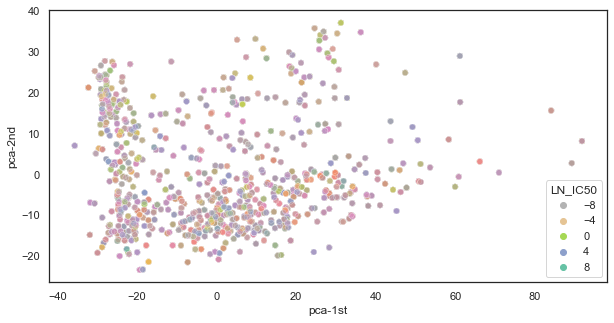

In [53]:
# 2d-version
plt.figure(figsize=(10, 5))
sns.scatterplot(
    x="pca-1st", y="pca-2nd",
    hue="LN_IC50",
    palette=sns.color_palette("Set2_r", as_cmap=True),
    data=merge_pca.loc[rndperm, :],
    alpha=0.3
);

/var/folders/kv/l0jzxgbj1kggff_kd35bfzkw0000gn/T/ipykernel_40712/1810180712.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = plt.figure(figsize=(16, 10)).gca(projection='3d');


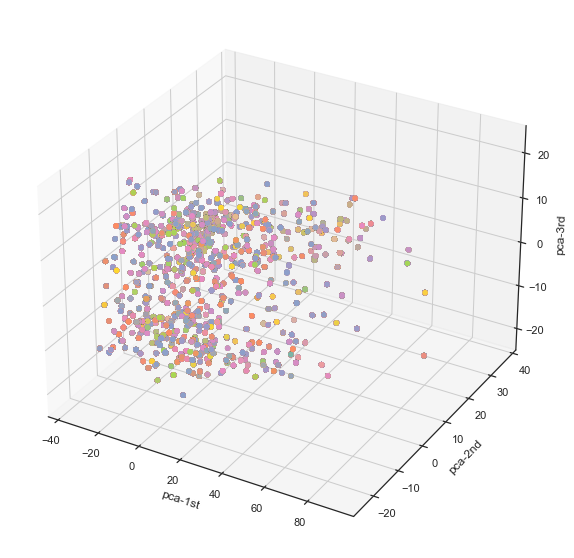

In [52]:
# 3d-version
pca_temp = merge_pca.loc[rndperm, :]
ax = plt.figure(figsize=(16, 10)).gca(projection='3d');
ax.scatter(
    xs=pca_temp["pca-1st"], 
    ys=pca_temp["pca-2nd"], 
    zs=pca_temp["pca-3rd"], 
    c=pca_temp["LN_IC50"], 
    cmap='Set2_r'
)
ax.set_xlabel('pca-1st');
ax.set_ylabel('pca-2nd');
ax.set_zlabel('pca-3rd');
plt.show();

t-SNE

In [54]:
from sklearn.manifold import TSNE

In [56]:
tsne_merged = pd.merge(left=merge, right=cl_mat_pca, on=['CELL_LINE_NAME'], how='left')

In [57]:
df_subset = tsne_merged.loc[rndperm[:10_000],:]

In [58]:
print(df_subset.shape)
df_subset.head(3)

(10000, 6872)


,CELL_LINE_NAME,DRUG_ID,DRUG_NAME,DATASET,LN_IC50,FBXL12_gexpr_x,PIN1_gexpr_x,PAK4_gexpr_x,GNA15_gexpr_x,ARPP19_gexpr_x,...,ETS1_mut_y,EBNA1BP2_mut_y,MYL9_mut_y,MLLT11_mut_y,PFKL_mut_y,FGFR4_mut_y,SDHB_mut_y,pca-1st,pca-2nd,pca-3rd
10930,CESS,1463,AZD1332,GDSC2,3.291754,7.933905,5.322235,3.837551,5.921490,7.816132,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-26.869466,9.443866,-8.631940
16879,DMS-53,2096,VX-11e,GDSC2,1.978736,6.266880,5.341163,4.314252,3.133045,6.503973,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,-4.341663,-2.448864,1.259656
69106,PCI-30,1560,Alpelisib,GDSC2,3.990089,7.471782,5.168262,3.767635,4.187586,6.536506,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.336742,-12.982065,10.978193


In [61]:
feature_cols.head(3)

,FBXL12_gexpr,PIN1_gexpr,PAK4_gexpr,GNA15_gexpr,ARPP19_gexpr,EAPP_gexpr,MOK_gexpr,MTHFD2_gexpr,TIPARP_gexpr,CASP3_gexpr,...,PDHX_mut,DFFB_mut,FOSL1_mut,ETS1_mut,EBNA1BP2_mut,MYL9_mut,MLLT11_mut,PFKL_mut,FGFR4_mut,SDHB_mut
0,7.023759,6.067534,4.318750,3.261427,6.297582,8.313991,5.514912,10.594112,5.222366,6.635925,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,6.714387,5.695096,4.536146,3.295886,7.021037,8.500080,4.862145,10.609245,6.528668,7.238143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.752402,5.475753,4.033714,3.176525,7.279671,8.013367,4.957332,11.266705,7.445954,6.312424,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [62]:
N = 10_000

tsne_merged = pd.merge(left=merge, right=cl_mat_pca, on=['CELL_LINE_NAME'], how='left')
print("Finished merging...")
df_subset = tsne_merged.loc[rndperm[:N], :]
print("Finished sampling...")

not_needed = ['CELL_LINE_NAME', 'DRUG_ID', 'DRUG_NAME', 'DATASET', 'LN_IC50']
data_subset = df_subset.loc[:, ~df_subset.columns.isin(not_needed)].values
print("Finished subsetting...")

pca = PCA(n_components=3)
pca_result = pca.fit_transform(data_subset)

df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]

print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Finished merging...
Finished sampling...
Finished subsetting...
Explained variation per principal component: [0.25535561 0.09387773 0.04364273]


In [1]:
df_subset.head(3)

NameError: name 'df_subset' is not defined

In [64]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_subset)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

/users/cwoest/Applications/anaconda3/envs/master-thesis-log/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/users/cwoest/Applications/anaconda3/envs/master-thesis-log/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.047s...
[t-SNE] Computed neighbors for 10000 samples in 24.076s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000


In [ ]:
df_subset['tsne-2d-one'] = tsne_results[:, 0]
df_subset['tsne-2d-two'] = tsne_results[:, 1]

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    # palette=sns.color_palette("hls", 10),
    data=df_subset,
    legend="full",
    alpha=0.3
)

## Build regression model

Now that we have a totally non-sparse matrix, we can build a simple regression model.

In [76]:
from sklearn.model_selection import train_test_split

X = df.loc[:, ~df.columns.isin(['LN_IC50'])]
y = df['LN_IC50']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, shuffle=True)
print(f"""Shapes
======
X_train: {str(X_train.shape):8s}   y_train: {str(y_train.shape):8s}
X_test : {str(X_test.shape):8s}   y_test : {str(y_test.shape):8s}
""")

Shapes
X_train: (78192, 3432)   y_train: (78192,)
X_test : (13799, 3432)   y_test : (13799,)



In [90]:
print("Number of cell-lines in train:", len(set(X_train.index.get_level_values('CELL_LINE_NAME').tolist())))
print("Number of cell-lines in test :", len(set(X_test.index.get_level_values('CELL_LINE_NAME').tolist())))

Number of cell-lines in train: 732
Number of cell-lines in test : 732
